# *Monod* demonstration: fit to neural cell subtypes

In the current notebook, we run the *Monod* inference pipeline on eight pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types, using a common set of 3,000 genes, a $20\times 21$ grid, and four models (bursty, constitutive, extrinsic, and CIR-like).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [19]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *

We already know the sampling parameters for glutamatergic cells. Instead of scanning over a grid, just pull them in from previous search results.

In [1]:
dataset_meta = ['A08', 'B01','B08','C01']

cluster_names = ['l5it','l6it','l6ct']
dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names] 
loom_filepaths = ['/home/ggorin/count_data/loom_allen_celltype_kb/test/'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=['spliced','unspliced','gene_name','barcode']

n_datasets = len(loom_filepaths)


In [4]:
result_strings

['./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220527_021_allen_celltypes_1/allen_B01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220527_021_allen_celltypes_1/allen_B08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220527_021_allen_celltypes_1/allen_C01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res']

In [35]:
dir_string_prev = './fits/gg_220527_021_allen_celltypes_1'
result_strings = [dir_string_prev+'/allen_'+x+'_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_meta]

so_ = []
for j in range(len(result_strings)):
    sr = load_search_results(result_strings[j])
    so_.append(sr.samp_optimum)


INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_C01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.


In [36]:
so_

[(-6.2631578947368425, -0.8999999999999999),
 (-6.2631578947368425, -0.8999999999999999),
 (-6.2631578947368425, -1.05),
 (-6.2631578947368425, -0.8999999999999999)]

In [43]:
so = np.zeros((n_datasets,2))
for i in range(n_datasets):
    so[i] = so_[i//len(cluster_names)]

In [44]:
so

array([[-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -1.05      ],
       [-6.26315789, -1.05      ],
       [-6.26315789, -1.05      ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ]])

## Preprocessing

Identify the genes to fit.

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_220601_022_allen_cellsubtypes_1 created.
INFO:root:Dataset: allen_A08_l5it
INFO:root:3140 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7443 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it created.
INFO:root:Dataset: allen_A08_l6it
INFO:root:199 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4900 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6it created.
INFO:root:Dataset: allen_A08_l6ct
INFO:root:1305 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6566 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6ct created.


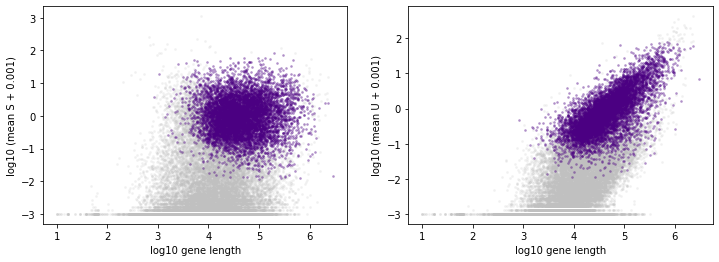

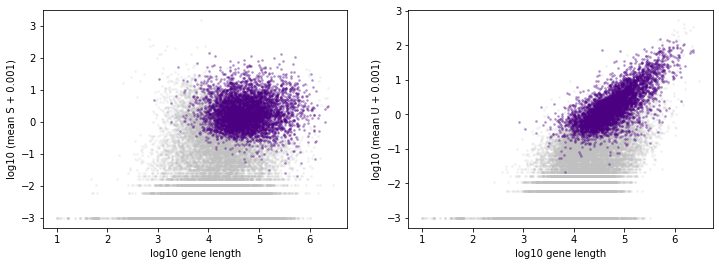

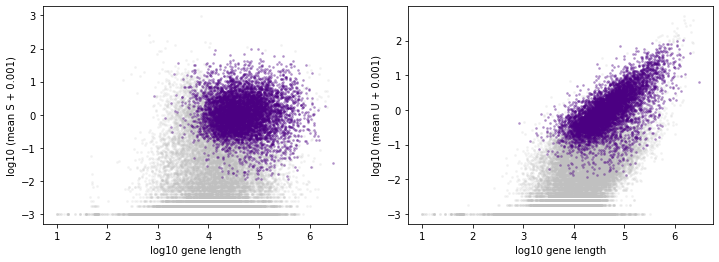

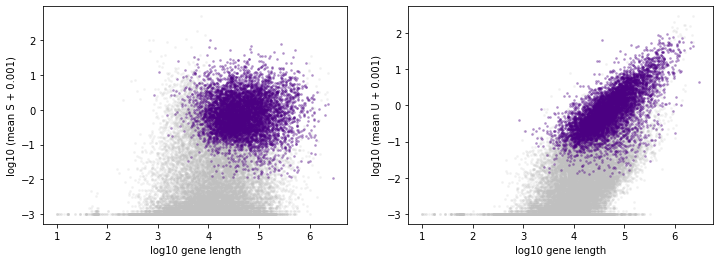

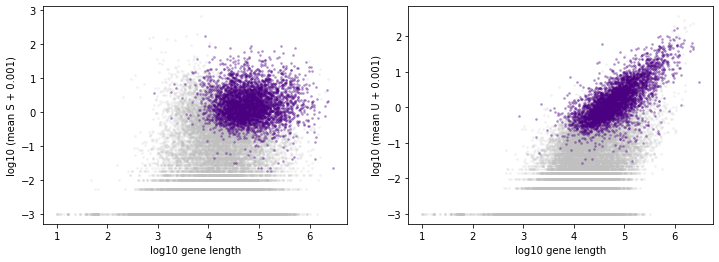

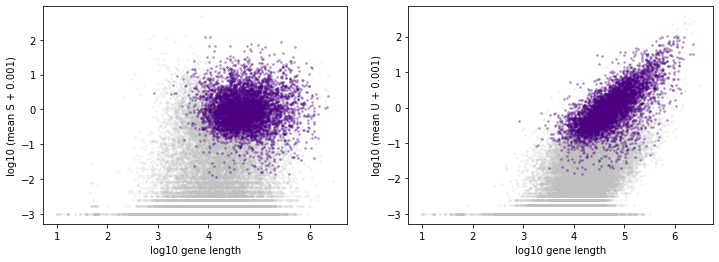

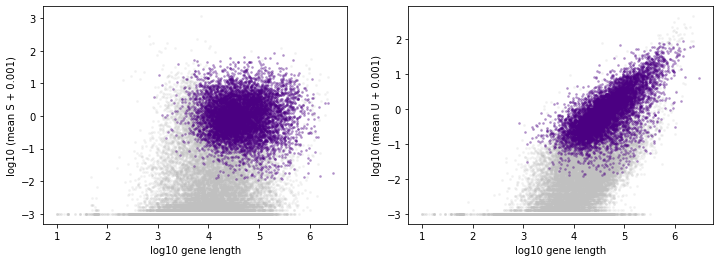

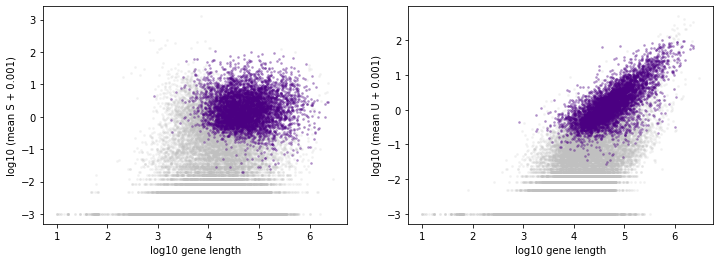

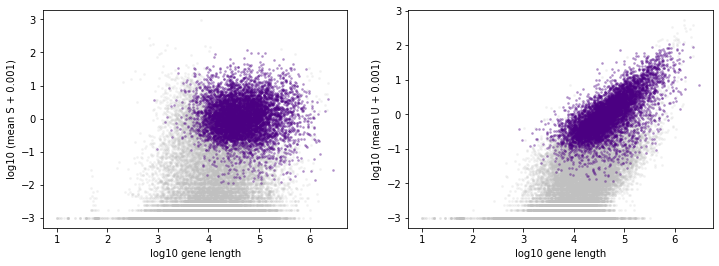

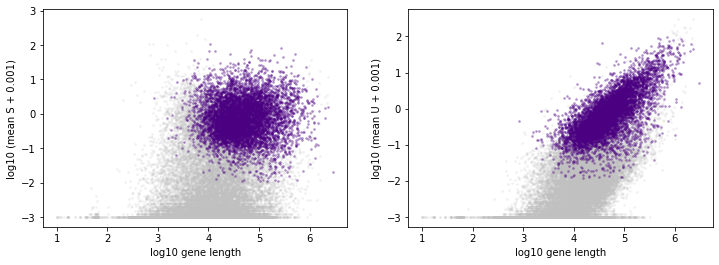

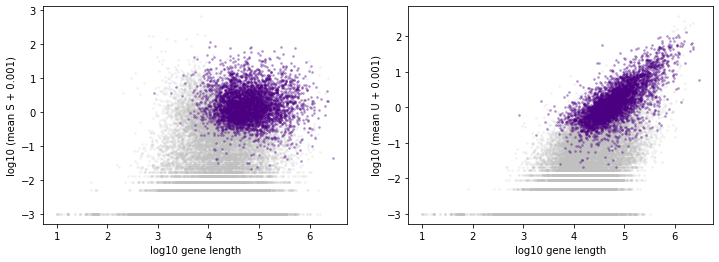

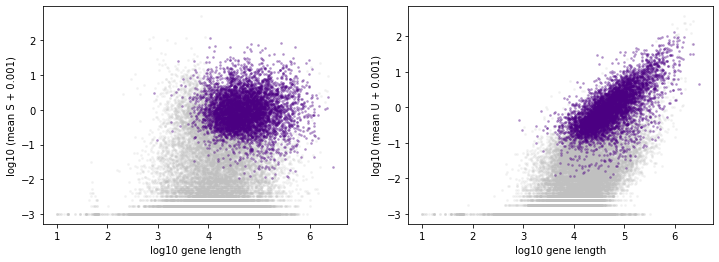

In [11]:
dir_string,dataset_strings = construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_cellsubtypes',batch_id=1,\
                                             n_genes=3000)

## Inference

Define parameter bounds, then iterate over datasets and perform the fits.

In [45]:
dataset_strings

['./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6it',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6ct',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l5it',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l6it',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l6ct',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l5it',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l6it',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l6ct',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_C01_l5it',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_C01_l6it',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_C01_l6ct']

INFO:root:Global inference parameters stored to ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_A08_l5it
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220601_022_allen_cellsubtypes_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 178.4 seconds.
INFO:root:Global inference parameters stored to ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6it/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_A08_l6it
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_2

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_l6ct
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220601_022_allen_cellsubtypes_1/genes.csv.
INFO:root:Directory ./fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l6ct/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l6ct/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l6ct/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 147.0 seconds.
INFO:root:Directory ./fits/gg_220601_022_allen_cellsubtypes_1/allen_C01_l5it/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220601_022_allen_cellsubtypes_1/allen_C01_l5it/Bursty_Poisson_1x1/parameters.pr.
INFO:root:

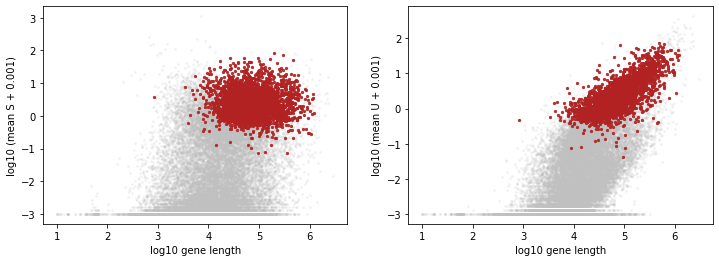

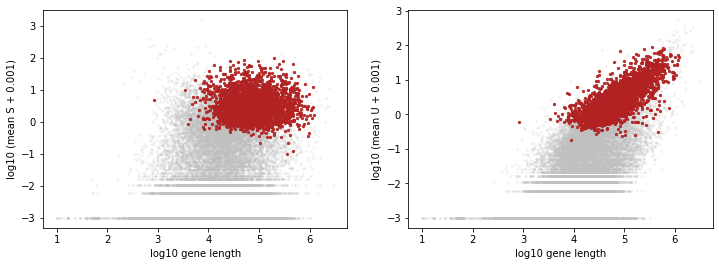

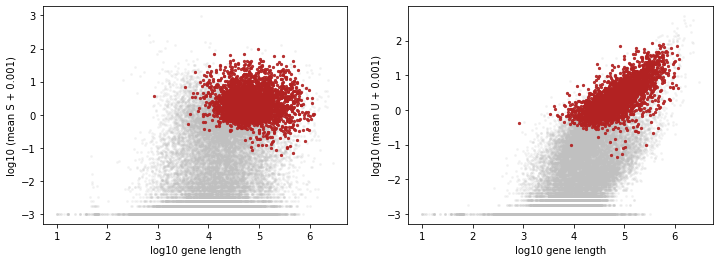

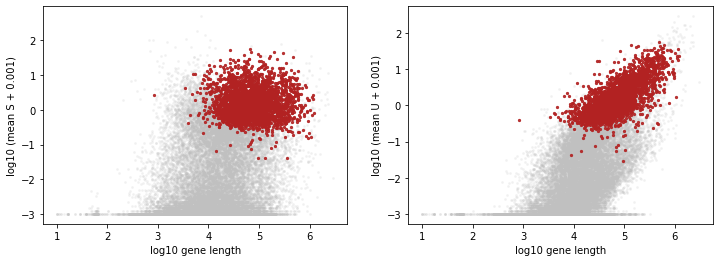

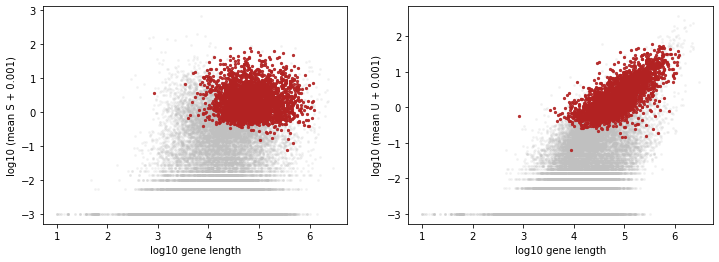

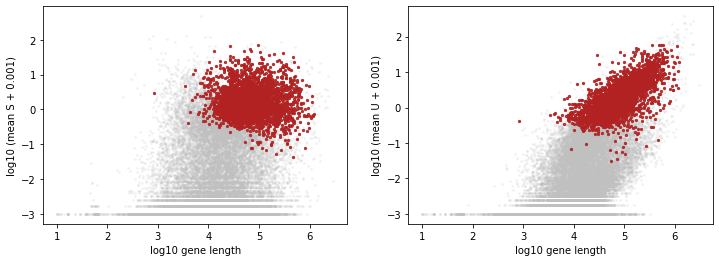

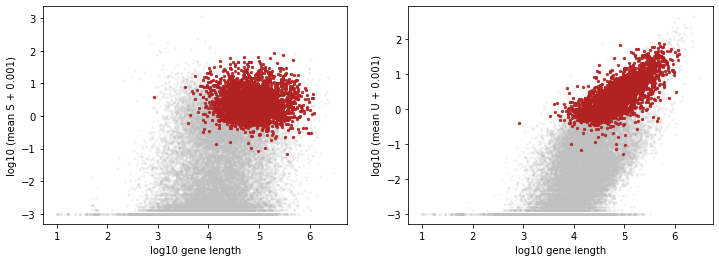

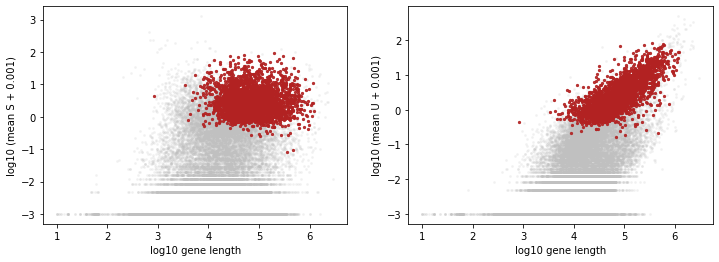

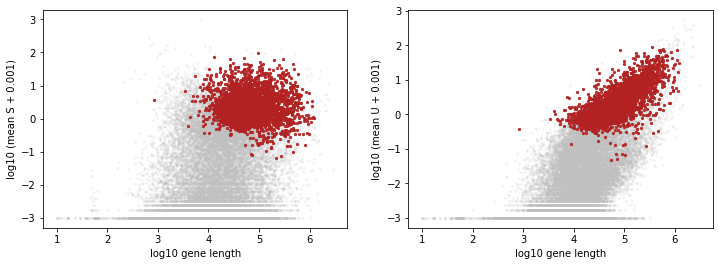

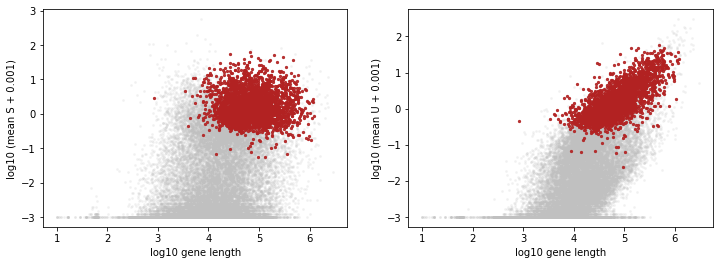

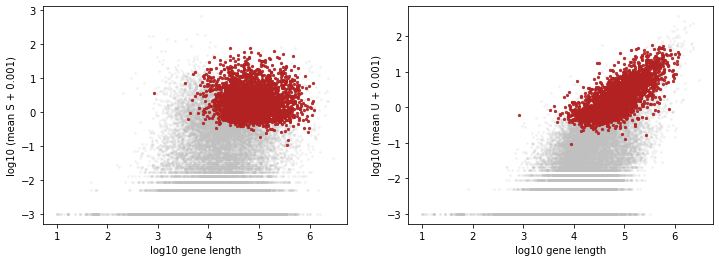

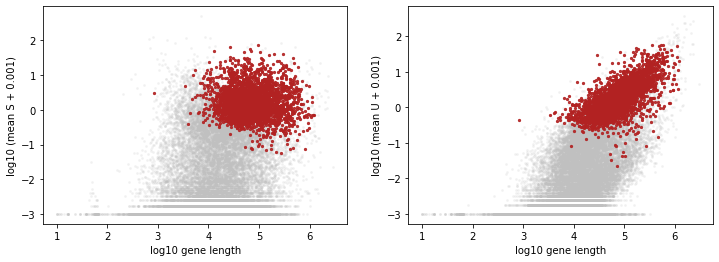

In [46]:
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
grid = [1,1]



result_strings = []
for i in range(n_datasets):
    fitmodel = CMEModel('Bursty','Poisson')
    inference_parameters = InferenceParameters(lb,ub,so[i],so[i],grid,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':10,'init_pattern':'moments','num_restarts':1})
    search_data = extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names)
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings.append(full_result_string)

In [47]:
sd_strings = [x+'/raw.sd' for x in dataset_strings]

In [48]:
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")


In [49]:
result_strings

['./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6ct/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l5it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l6it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l6ct/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l5it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l6it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l6ct/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_C01_l5it/Bursty_Poisson_1x1/grid

In [50]:
sr_arr = []
sd_arr = []


for j in range(n_datasets):
    sd = load_search_data(sd_strings[j])
    sr = load_search_results(result_strings[j])
    
    sd_arr.append(sd)
    sr_arr.append(sr)


INFO:root:Search data loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6it/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6ct/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6ct/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l5it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l5it/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_2206

In [51]:
make_batch_analysis_dir(sr_arr,dir_string)

INFO:root:Directory ./fits/gg_220601_022_allen_cellsubtypes_1/analysis_figures created.


In [58]:
#a e s t h e t i c s

fs = 16
nbin=40

#https://github.com/BlakeRMills/MetBrewer
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")


INFO:root:Figure stored to ./fits/gg_220601_022_allen_cellsubtypes_1/analysis_figures/kneeplots_all.png.


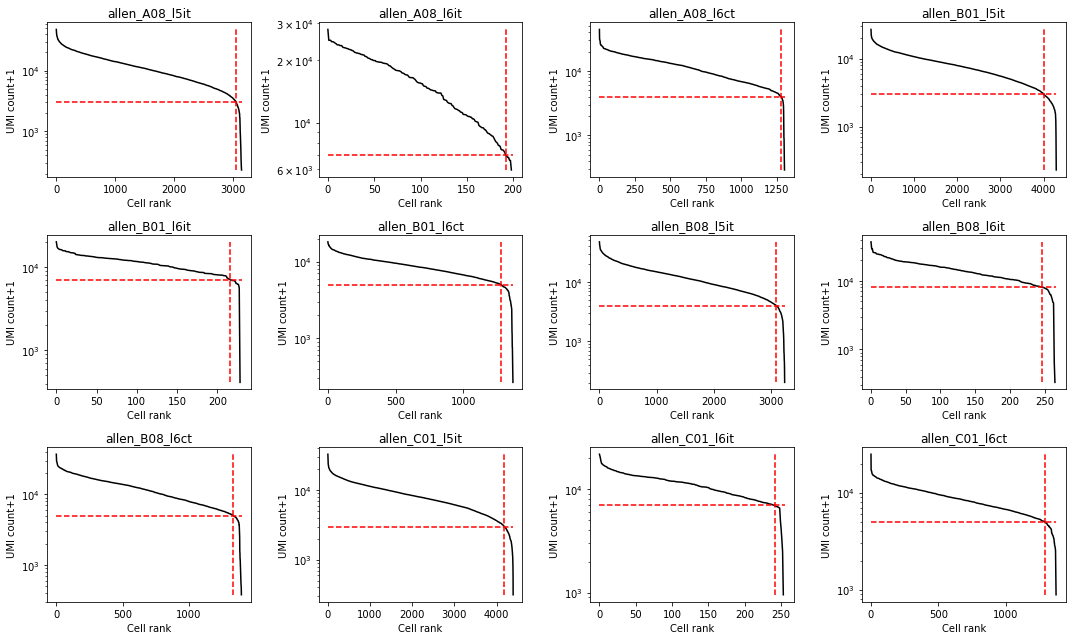

In [55]:
sz=(3,4)
fig1,ax1 = plt.subplots(sz[0],sz[1],figsize=(15,9))
thr = [3e3, 7e3, 4e3, 3e3, 
       7e3, 5e3, 4e3, 8e3,
       5e3, 3e3, 7e3, 5e3]
for j in range(n_datasets):
    axloc=np.unravel_index(j,sz)
    sd_arr[j].knee_plot(ax1=ax1[axloc],viz=True,thr=thr[j])
    ax1[axloc].set_title(dataset_names[j])
fig1.tight_layout()


analysis_dir_string = sr_arr[0].batch_analysis_string
fig_string = analysis_dir_string+'/kneeplots_all.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


In [88]:
f_tech_naive = []
f_mech = []

for j in range(n_datasets):
    f_tech_naive.append(sd_arr[j].get_noise_decomp(knee_thr=thr[j])[:,1,1])
    sr_arr[j].find_sampling_optimum()
    d = sr_arr[j].get_noise_decomp()
#     f_mech.append(d[:,2,1]) #tech noise
    f_mech.append(d[:,1,1]+ d[:,0,1]) # bio noise
    
f_tech_naive = np.asarray(f_tech_naive)
f_mech = np.asarray(f_mech)


Text(0, 0.5, 'Density')

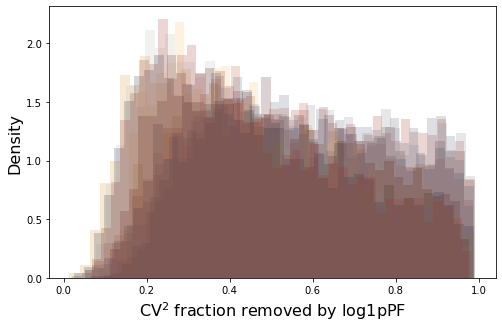

In [64]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.hist(f_tech_naive[j],nbin,alpha=0.2,density=True,facecolor=c,label=dataset_names[j])
plt.xlabel(r'CV$^2$ fraction removed by log1pPF',fontsize=fs)
plt.ylabel('Density',fontsize=fs)
# plt.legend()


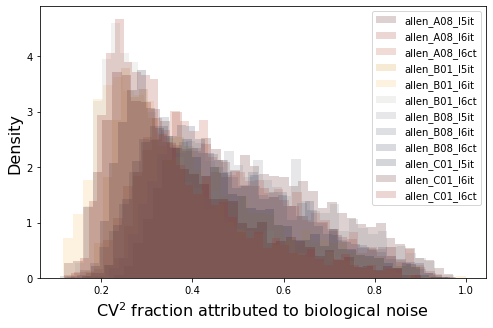

In [89]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.hist(f_mech[j],nbin,alpha=0.2,density=True,facecolor=c,label=dataset_names[j])
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
# plt.xlabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.ylabel('Density',fontsize=fs)
plt.legend()


INFO:root:Figure stored to ./fits/gg_220601_022_allen_cellsubtypes_1/analysis_figures/CV2_noise.png.


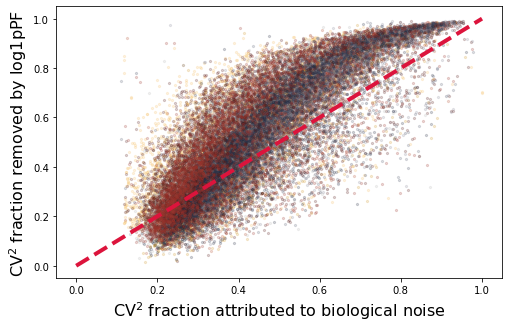

In [90]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(f_mech[j],f_tech_naive[j],s=5,alpha=0.2,c=c)
plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4)
# plt.xlabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction removed by log1pPF',fontsize=fs)

fig_string = analysis_dir_string+'/CV2_noise.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


In [76]:
Svar = []
for j in range(n_datasets):
    Svar.append([x['S_var'] for x in sd_arr[j].moments])
Svar = np.asarray(Svar)

In [84]:
Smean = []
for j in range(n_datasets):
    Smean.append([x['S_mean'] for x in sd_arr[j].moments])
Smean = np.asarray(Smean)

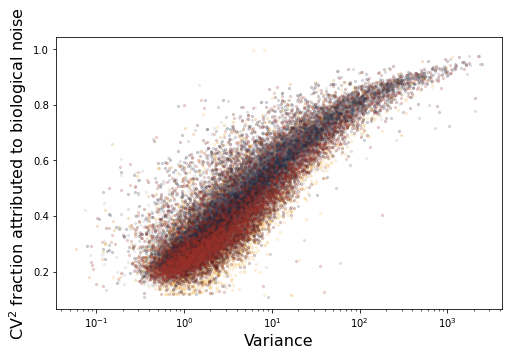

In [95]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Svar[j],f_mech[j],s=5,alpha=0.2,c=c)
# plt.ylabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.xlabel(r'Variance',fontsize=fs)
plt.xscale('log')


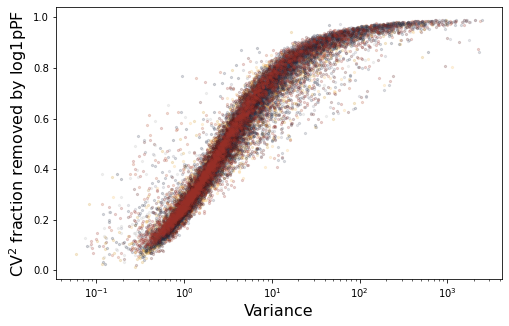

In [96]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Svar[j],f_tech_naive[j],s=5,alpha=0.2,c=c)
plt.ylabel(r'CV$^2$ fraction removed by log1pPF',fontsize=fs)
plt.xlabel(r'Variance',fontsize=fs)
plt.xscale('log')


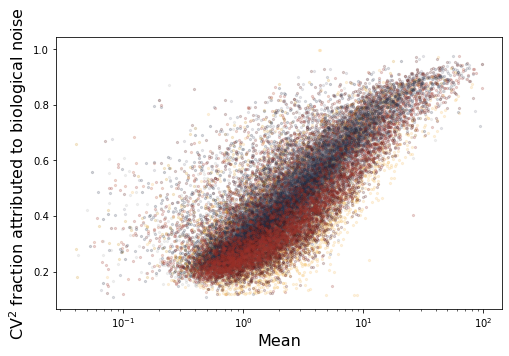

In [97]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Smean[j],f_mech[j],s=5,alpha=0.2,c=c)
# plt.ylabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.xlabel(r'Mean',fontsize=fs)
plt.xscale('log')

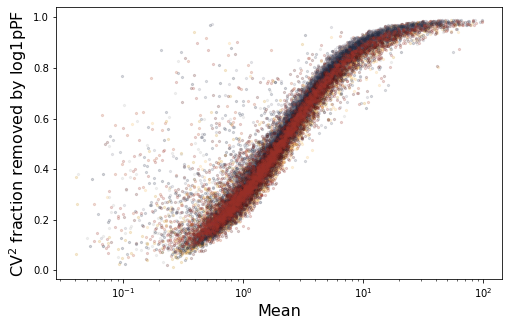

In [98]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Smean[j],f_tech_naive[j],s=5,alpha=0.2,c=c)
# plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4)
# plt.ylabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction removed by log1pPF',fontsize=fs)
plt.xlabel(r'Mean',fontsize=fs)
plt.xscale('log')

# fig_string = analysis_dir_string+'/CV2_noise.png'
# plt.savefig(fig_string,dpi=450)
# log.info('Figure stored to {}.'.format(fig_string))


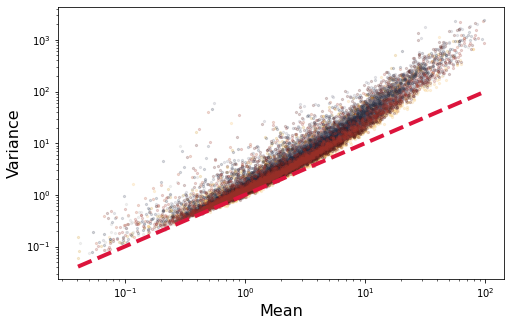

In [112]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Smean[j],Svar[j],s=5,alpha=0.2,c=c)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'Variance',fontsize=fs)
plt.xlabel(r'Mean',fontsize=fs)
xl = [Smean.min(),Smean.max()]
plt.plot(xl,xl,'--',c='crimson',linewidth=4)


Text(0, 0.5, 'Fano')

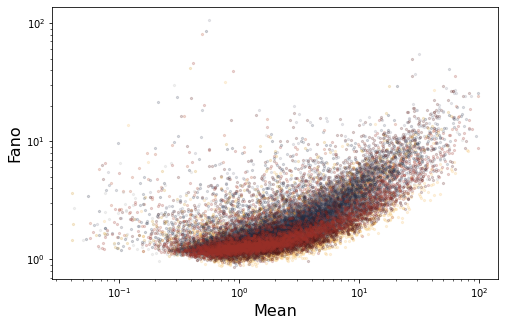

In [107]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Smean[j],Svar[j]/Smean[j],s=5,alpha=0.2,c=c)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Mean',fontsize=fs)
plt.ylabel(r'Fano',fontsize=fs)
